<a href="https://colab.research.google.com/github/valerian-drmt/Finance/blob/main/Projects/LSTM_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Setup Library and Import

In [2]:
!pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.4 MB/s eta 0:00:00


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import vectorbt as vbt
import time
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.metrics import r2_score
from scipy.stats import norm

# 2) Get and Modify Data

| Interval       | Max Lookback Period (approx)  |
|----------------|-------------------------------|
| `'1m'`         | 7 days                        |
| `'2m'`         | 60 days                       |
| `'5m'`         | 60 days                       |
| `'15m'`        | 60 days                       |
| `'30m'`        | 60 days                       |
| `'60m'` / `'1h'` | 730 days (~2 years)        |
| `'1d'`         | ~20+ years                    |
| `'1wk'`        | ~20+ years                    |
| `'1mo'`        | ~20+ years                    |

In [25]:
ticker_Binance = "BTCUSDT"
ticker_YFinance = "BTC-USD"
start = "2025-04-7"
end = "2025-04-11"
interval = "5m"

#data_request = vbt.BinanceData.download(ticker_Binance, start= start, end = end, interval = interval)
data_request = vbt.YFData.download(ticker_YFinance, start= start, end = end, interval = interval)
data = data_request.get()
print("Data size:",data.shape)
print(data.head())

#data.vbt.ohlcv.plot(plot_type="candlestick",show_volume=True)
#plt.plot(data.index,data["Close"])
#plt.show()

Data size: (1152, 7)
                                   Open          High           Low  \
Datetime                                                              
2025-04-07 00:00:00+00:00  78337.906250  78411.726562  78273.507812   
2025-04-07 00:05:00+00:00  77878.679688  78029.468750  77878.679688   
2025-04-07 00:10:00+00:00  77873.078125  77873.078125  77450.367188   
2025-04-07 00:15:00+00:00  77411.085938  77876.250000  77411.085938   
2025-04-07 00:20:00+00:00  77815.078125  77897.929688  77757.054688   

                                  Close      Volume  Dividends  Stock Splits  
Datetime                                                                      
2025-04-07 00:00:00+00:00  78273.507812           0        0.0           0.0  
2025-04-07 00:05:00+00:00  77909.281250   796631040        0.0           0.0  
2025-04-07 00:10:00+00:00  77450.367188           0        0.0           0.0  
2025-04-07 00:15:00+00:00  77869.960938  1211973632        0.0           0.0  
2025-04

In [75]:
def extend_OHLC_in_data(data):
  input = pd.DataFrame(index = data.index, data = {"Open" :data["Open"],
                                                "High": data["High"],
                                                "Low": data["Low"],
                                                "Close": data["Close"],
                                                "Volume": data["Volume"],
                                                  })

  rows = []
  for t, row in input.iterrows():
    o,h,l,c,v= row["Open"], row["High"], row["Low"], row["Close"], row["Volume"]
    v_row = v/4

    if o>=c:
      values= [o,h,l,c]
    else:
      values =[o,l,h,c]

    for value in values:
      rows.append({"Datetime": t,
                  "Price": value,
                  "Volume": v_row})

  input = pd.DataFrame(rows)
  #input.set_index("Datetime", inplace=True)
  return input

input = extend_OHLC_in_data(data)
print("Data Shape:",data.shape)
print("Input Shape:",input.shape)
print(input)
show_plot  = False
if show_plot:
  plt.plot(input["Price"])
  plt.show()

Data Shape: (1152, 7)
Input Shape: (4608, 3)
                      Datetime         Price       Volume
0    2025-04-07 00:00:00+00:00  78337.906250          0.0
1    2025-04-07 00:00:00+00:00  78411.726562          0.0
2    2025-04-07 00:00:00+00:00  78273.507812          0.0
3    2025-04-07 00:00:00+00:00  78273.507812          0.0
4    2025-04-07 00:05:00+00:00  77878.679688  199157760.0
...                        ...           ...          ...
4603 2025-04-10 23:50:00+00:00  79597.914062  190967808.0
4604 2025-04-10 23:55:00+00:00  79602.421875          0.0
4605 2025-04-10 23:55:00+00:00  79602.421875          0.0
4606 2025-04-10 23:55:00+00:00  79550.281250          0.0
4607 2025-04-10 23:55:00+00:00  79560.148438          0.0

[4608 rows x 3 columns]


           Price  Category
0   78337.906250       NaN
1   78411.726562       NaN
2   78273.507812       NaN
3   78273.507812       NaN
4   77878.679688       NaN
5   77878.679688       NaN
6   78029.468750       NaN
7   77909.281250       NaN
8   77873.078125       NaN
9   77873.078125       NaN
10  77450.367188       NaN
11  77450.367188       NaN
12  77411.085938       NaN
13  77411.085938       NaN
14  77876.250000       NaN
15  77869.960938       NaN
16  77815.078125       NaN
17  77897.929688       NaN
18  77757.054688       NaN
19  77757.054688       3.0
20  77847.460938       3.0
21  77847.460938       2.0
22  78219.687500       1.0
23  78219.687500       1.0
24  78245.664062       2.0
25  78245.664062       2.0
26  78016.765625       4.0
27  78016.765625       4.0


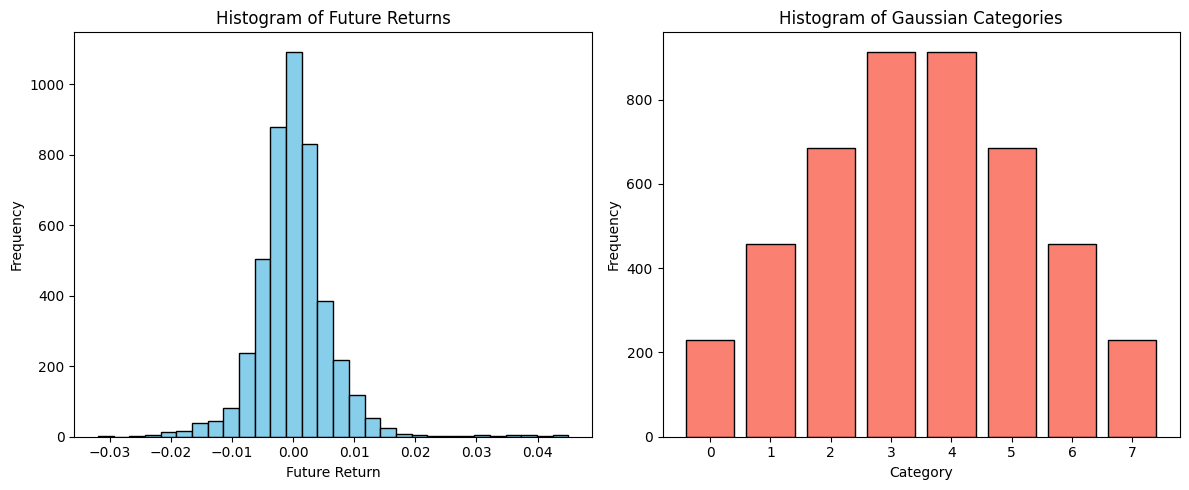

In [89]:
output = pd.DataFrame(input["Price"])

from scipy.stats import norm
# Parameters
n = 8  # number of categories
look_forward = 20
target_frequencies = [0.05, 0.10, 0.15, 0.20, 0.20, 0.15, 0.10, 0.05]  # Must sum to 1

# Step 1: Calculate future returns and rolling stats
output["Future Return"] = output["Price"].shift(-look_forward) / output["Price"] - 1
output["Return Mean"] = output["Future Return"].rolling(window=look_forward).mean()
output["Return Std"] = output["Future Return"].rolling(window=look_forward).std()
output["Return Z-Score"] = (output["Future Return"] - output["Return Mean"]) / output["Return Std"]

# Drop NaNs to compute quantiles
valid_z = output["Return Z-Score"].dropna()

# Step 2: Compute quantile boundaries from actual distribution using cumulative target frequencies
cum_freq = np.cumsum(target_frequencies)
quantile_cutoffs = valid_z.quantile(cum_freq[:-1])  # we don't need the last (1.0) since it's +inf
boundaries = [-np.inf] + list(quantile_cutoffs.values) + [np.inf]

# Step 3: Categorize Z-scores
def categorize_zscore(z, bounds):
    if pd.isna(z):
        return np.nan
    for i in range(len(bounds) - 1):
        if bounds[i] <= z < bounds[i + 1]:
            return i

output["Category"] = output["Return Z-Score"].apply(lambda z: categorize_zscore(z, boundaries))

# Optional: cleanup
output.drop(columns=["Future Return", "Return Mean", "Return Std", "Return Z-Score"], inplace=True)

# Display result
print(output.head(n + look_forward))

#-------------------------------------------------------------------------------
# Verification
plt.figure(figsize=(12, 5))

# Histogramme des future returns
plt.subplot(1, 2, 1)
plt.hist(output["Price"].pct_change(look_forward).dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Future Returns")
plt.xlabel("Future Return")
plt.ylabel("Frequency")

# Histogramme des catégories gaussiennes
plt.subplot(1, 2, 2)
plt.hist(output["Category"].dropna(), bins=np.arange(n+1)-0.5, color='salmon', edgecolor='black', rwidth=0.8)
plt.xticks(range(n))
plt.title("Histogram of Gaussian Categories")
plt.xlabel("Category")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [47]:
# @title
def split_data(input, lookback, size_test_prct):
    input = (input-input.min())/(input.max()-input.min())
    data_raw = np.array(input) # convert to numpy array
    data = []
    lookback+=1 # +1 for output variable

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)

    test_set_size = int(np.round(size_test_prct*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)

    return [x_train, y_train, x_test, y_test]

# 3) Setup LSTM Definition

In [48]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.lstm_layers = nn.ModuleList()

        # Première couche LSTM
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_dim[0], batch_first=True))

        # Couches suivantes
        for i in range(1, self.num_layers):
            self.lstm_layers.append(nn.LSTM(hidden_dim[i-1], hidden_dim[i], batch_first=True))

        # Couche linéaire finale
        self.fc = nn.Linear(hidden_dim[-1], output_dim)

    def forward(self, x):
        out = x
        for lstm in self.lstm_layers:
            out, _ = lstm(out)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

Function to Delete Training Data Variables

In [49]:
# @title
def del_train_data(list):
  for var in list:
    if var in locals():
        del globals()[var]

Function to Initialize Metrics Tracking

In [50]:
# @title
def metrics_setup():

  # Tracking
  hist_rmse = np.zeros(num_epochs)
  hist_mae = np.zeros(num_epochs)
  hist_r2 = np.zeros(num_epochs)
  hist_mape = np.zeros(num_epochs)
  MSE = torch.nn.MSELoss(reduction='mean')
  MAE = torch.nn.L1Loss(reduction='mean')

  return [MSE, MAE, hist_rmse,hist_mae,hist_r2,hist_mape]

Function to Update Model Metrics

In [51]:
# @title
def update_metrics(y_train_pred, y_train, MSE, MAE):
  # Compute losses
    mse_value = MSE(y_train_pred, y_train)
    rmse_value = torch.sqrt(mse_value)
    mae_value = MAE(y_train_pred, y_train)

    # Detach predictions for R2 and MAPE
    y_pred_np = y_train_pred.detach().cpu().numpy()
    y_true_np = y_train.detach().cpu().numpy()

    # R² Score
    r2_value = r2_score(y_true_np, y_pred_np)

    # MAPE (add small epsilon to avoid division by zero)
    epsilon = 1e-3
    mape_value = np.mean(np.abs((y_true_np - y_pred_np) / (y_true_np + epsilon))) * 100


    return [mse_value, rmse_value.item(), mae_value.item(), r2_value, mape_value]

# 4) Setup Data Pisplay Definition

Function to Plot Training Metrics Over Epochs

In [52]:
# @title
# Affichage des métriques
def plot_metrics(hist_rmse,hist_mae,hist_r2,hist_mape):
  fig, axs = plt.subplots(1, 3, figsize=(18, 5))

  # RMSE & MAE
  axs[0].plot(hist_rmse, label="RMSE")
  axs[0].plot(hist_mae, label="MAE")
  axs[0].set(title="RMSE & MAE", xlabel="Epoch", ylabel="Error")
  axs[0].legend()

  # R²
  axs[1].plot(hist_r2)
  axs[1].set(title="R² Score", xlabel="Epoch", ylabel="R²")

  # MAPE
  axs[2].plot(hist_mape)
  axs[2].set(title="MAPE (%)", xlabel="Epoch", ylabel="MAPE")

  plt.tight_layout(rect=[0, 0.03, 1, 0.90])
  plt.show()

Function to Plot Model Predictions Against Actual Data

In [53]:
# @title
def plot_train_test_prediction(y_train,y_train_pred,y_test,y_test_pred):
  common_style = {
      'xlabel': 'Sample Index',
      'ylabel': 'Value',
      'legend_loc': 'best',
      'data_color': 'blue',
      'pred_color': 'orange',
      'pred_linestyle': '--',
      'titles': ['Train Data and Model Predictions', 'Test Data and Model Predictions']
  }

  # Create a figure with 1 row and 2 columns of subplots
  fig, ax = plt.subplots(1, 2, figsize=(18, 3))

  # Data and prediction lists for loop
  data_and_pred = [
      (y_train.detach().cpu().numpy()[-150:], y_train_pred.detach().cpu().numpy()[-150:], 'train'),
      (y_test[-150:], y_test_pred.detach().cpu().numpy()[-150:], 'test')
  ]

  # Plot data and predictions
  for i, (data, pred, label_prefix) in enumerate(data_and_pred):
      ax[i].plot(data, label=f'{label_prefix} data', color=common_style['data_color'])
      ax[i].plot(pred, label=f'{label_prefix} prediction', color=common_style['pred_color'], linestyle=common_style['pred_linestyle'])
      ax[i].set_title(common_style['titles'][i])
      ax[i].set_xlabel(common_style['xlabel'])
      ax[i].set_ylabel(common_style['ylabel'])
      ax[i].legend(loc=common_style['legend_loc'])

  # Apply tight layout for better spacing
  plt.tight_layout()
  plt.show()

Function to Display Model Performance Metrics

In [54]:
# @title
def show_metrics(y_test, y_test_pred, hist_rmse, hist_mae, hist_r2, hist_mape):
    y_test_pred_np = y_test_pred.detach().cpu().numpy()
    y_test_np = y_test.detach().cpu().numpy()

    # Compute losses for the test set
    mse_test = MSE(y_test_pred, y_test)
    rmse_test = torch.sqrt(mse_test).item()
    mae_test = MAE(y_test_pred, y_test).item()

    # Compute R² Score for the test set
    r2_value_test = r2_score(y_test_np, y_test_pred_np)

    # MAPE for the test set (add small epsilon to avoid division by zero)
    epsilon = 1e-8
    mape_value_test = np.mean(np.abs((y_test_np - y_test_pred_np) / (y_test_np + epsilon))) * 100

    # Create a dataframe with train and test metrics
    metrics_data = {
        'Train': [hist_rmse, hist_mae, hist_r2, hist_mape],
        'Test': [rmse_test, mae_test, r2_value_test, mape_value_test]
    }

    metrics_df = pd.DataFrame(metrics_data, index=['RMSE', 'MAE', 'R²', 'MAPE'])

    # Print the dataframe
    print(metrics_df)

# 5) Train, Test and Plot LSTM Model

à rajouter:
- input : 3 dims valeur (0 ou 1) pour les 3 marché NY,London et HK
- input : 4 dims 2 high, 2 low
- output : valeur look forward et division de la gausienne, mettre valeur jusqu'à n

In [57]:
lookback = 20
look_forward = lookback*0.2
size_test_prct = 0.3
input_dim = 1
hidden_dim = [32,32]
num_layers = len(hidden_dim)
output_dim = 1
num_epochs = 60
input = pd.DataFrame(input["Price"])

Epoch 1 / RMSE: 0.32998 / MAE: 0.28569 / R²: -2.77756 / MAPE: 76.34%
Epoch 10 / RMSE: 0.16305 / MAE: 0.13052 / R²: 0.07774 / MAPE: 67.98%
Epoch 20 / RMSE: 0.05537 / MAE: 0.04258 / R²: 0.89365 / MAPE: 35.06%
Epoch 30 / RMSE: 0.06214 / MAE: 0.04825 / R²: 0.86603 / MAPE: 31.94%
Epoch 40 / RMSE: 0.03830 / MAE: 0.02932 / R²: 0.94911 / MAPE: 14.93%
Epoch 50 / RMSE: 0.03520 / MAE: 0.02677 / R²: 0.95701 / MAPE: 19.71%
Epoch 60 / RMSE: 0.02844 / MAE: 0.02002 / R²: 0.97195 / MAPE: 11.14%
---------------------------------
Training time: 31.412073373794556
---------------------------------
          Train      Test
RMSE   0.028437  0.034943
MAE    0.020019  0.027501
R²     0.971945  0.939684
MAPE  11.137674  3.437711
---------------------------------


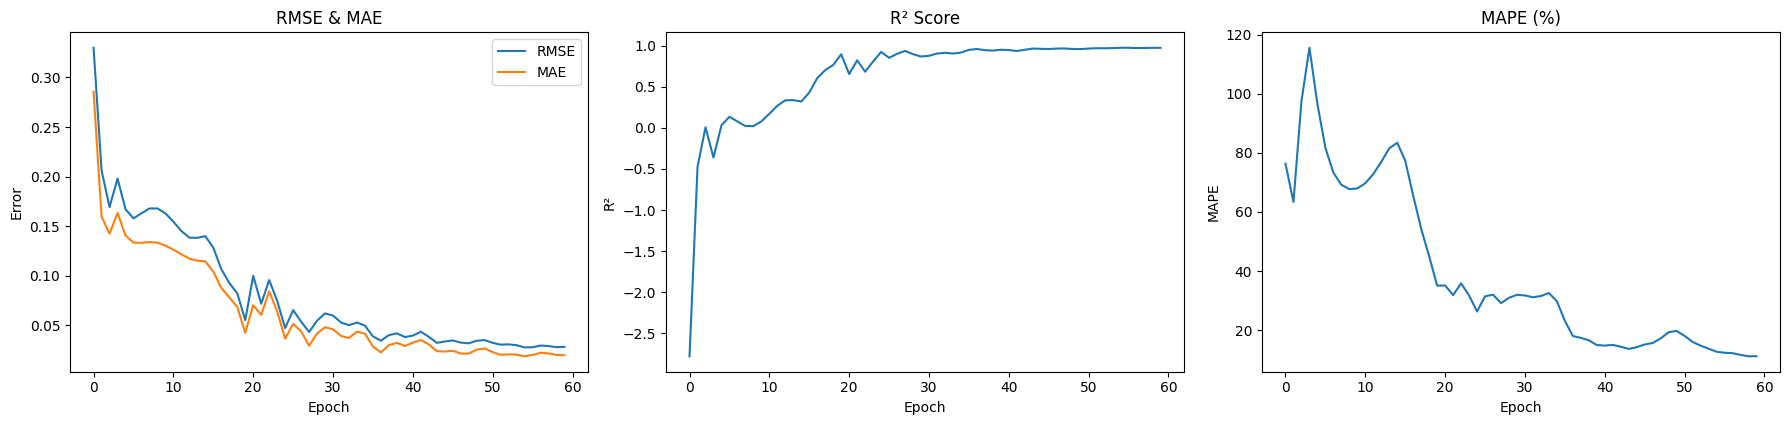

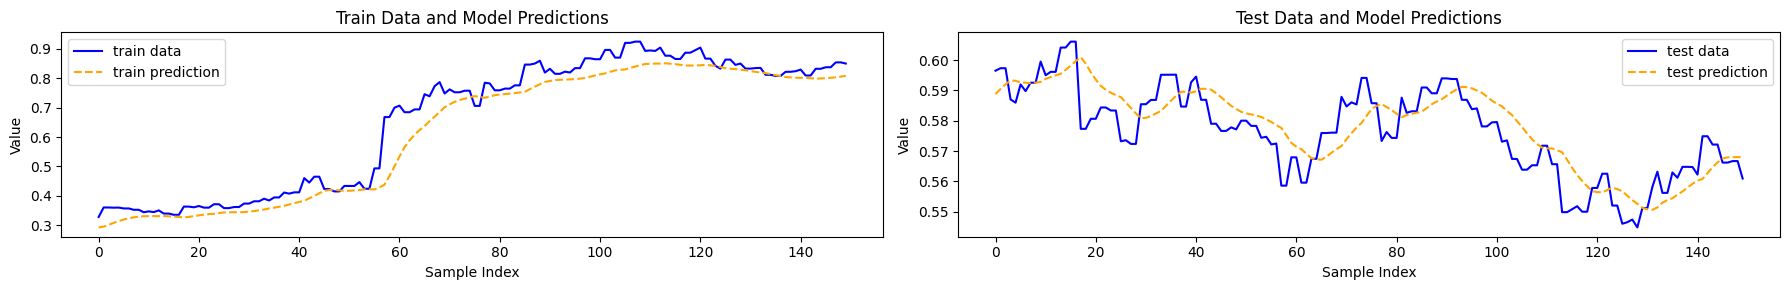

In [58]:
# Supprimer les data du train précédent
del_train_data(['model', 'optimiser', 'MSE', 'MAE'])

#-------------------------------------------------------------------------------
# Model Setup
x_train, y_train, x_test, y_test = split_data(input, lookback, size_test_prct)

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss functions
MSE, MAE, hist_rmse, hist_mae, hist_r2, hist_mape = metrics_setup()

#-------------------------------------------------------------------------------

start_time = time.time()

for t in range(num_epochs):
    model.train()
    y_train_pred = model(x_train)

    mse_value, hist_rmse[t], hist_mae[t], hist_r2[t], hist_mape[t] = update_metrics(y_train_pred, y_train, MSE, MAE)

    # Logging
    if (t+1)%10==0 or t==0:
      print(f"Epoch {t+1} / RMSE: {hist_rmse[t]:.5f} / MAE: {hist_mae[t]:.5f} / R²: {hist_r2[t]:.5f} / MAPE: {hist_mape[t]:.2f}%")

    # Backprop
    optimiser.zero_grad()
    mse_value.backward()
    optimiser.step()

training_time = time.time()-start_time
print("---------------------------------\nTraining time: {}\n---------------------------------".format(training_time))

#-------------------------------------------------------------------------------
model.eval()
with torch.no_grad():
    y_test_pred = model(x_test)

#-------------------------------------------------------------------------------
# Affichage des métriques
show_metrics(y_test,y_test_pred,hist_rmse[-1],hist_mae[-1],hist_r2[-1],hist_mape[-1])
print("---------------------------------")
plot_metrics(hist_rmse,hist_mae,hist_r2,hist_mape)

# Affichage des graphiques avec les prédictions
plot_train_test_prediction(y_train,y_train_pred,y_test,y_test_pred)
